In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
# Basic
import pandas as pd
import numpy as np

# Visualization (optional)
import matplotlib.pyplot as plt

# NLP / DL
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Transformers
!pip install -q transformers
from transformers import AutoTokenizer, AutoModel


In [ ]:

import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, roc_curve, auc
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize



# Deep Learning Libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
    TrainingArguments,
    Trainer
)
from torch import nn
from transformers import Trainer, EarlyStoppingCallback
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, jaccard_score, roc_auc_score


print("="*70)
print("ECG NLP REPORT ANALYZER")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Centralized configuration"""
    # Paths
    SCP_PATH = '/content/drive/MyDrive/NLP ECG /scp_statements.csv'
    PTB_PATH = '/content/drive/MyDrive/NLP ECG /ptbxl_database.csv'
    SAVE_DIR = '/content/drive/MyDrive/NLP ECG /models/'

    # Model settings
    MODEL_NAME = 'xlm-roberta-base'  # Handles English AND German!
    MAX_LENGTH = 256
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 10

    # Data filtering
    MIN_SAMPLES_PER_CLASS = 50  # Only train on common diagnoses
    TEST_SIZE = 0.2
    VAL_SIZE = 0.1

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()

# ============================================================================
# STEP 1: LOAD AND EXPLORE DATA
# ============================================================================

print("\n" + "="*70)
print("STEP 1: LOADING DATA")
print("="*70)

# Load datasets
scp_df = pd.read_csv(config.SCP_PATH)
ptb_df = pd.read_csv(config.PTB_PATH)

print(f"✓ SCP Statements loaded: {scp_df.shape}")
print(f"✓ PTB-XL Database loaded: {ptb_df.shape}")

# Show available columns
print(f"\nAvailable columns: {ptb_df.columns.tolist()}")

# Check what text columns exist
text_cols = [col for col in ptb_df.columns if 'report' in col.lower() or
             'text' in col.lower() or 'comment' in col.lower()]
print(f"Text columns found: {text_cols}")

# ============================================================================
# STEP 2: UNDERSTAND THE DATA STRUCTURE
# ============================================================================

print("\n" + "="*70)
print("STEP 2: DATA STRUCTURE ANALYSIS")
print("="*70)

# Show sample row
print("\nSample patient data:")
sample = ptb_df.iloc[0]
for col in ['ecg_id', 'patient_id', 'age', 'sex', 'scp_codes', 'report']:
    if col in ptb_df.columns:
        print(f"  {col}: {sample[col]}")

# Analyze scp_codes structure
print("\nSCP codes format:")
print(f"  Type: {type(ptb_df['scp_codes'].iloc[0])}")
print(f"  Sample: {ptb_df['scp_codes'].iloc[0]}")

# ============================================================================
# STEP 3: PARSE LABELS (DIAGNOSES)
# ============================================================================

print("\n" + "="*70)
print("STEP 3: PARSING DIAGNOSIS LABELS")
print("="*70)

def parse_scp_codes(scp_string):
    """
    Parse diagnosis codes from PTB-XL format
    Input: "{'NORM': 100.0, 'IMI': 50.0}"
    Output: ['NORM', 'IMI']
    """
    if pd.isna(scp_string):
        return []

    try:
        if isinstance(scp_string, str):
            codes_dict = ast.literal_eval(scp_string)
        else:
            codes_dict = scp_string
        return list(codes_dict.keys())
    except:
        return []

# Parse all labels
ptb_df['labels'] = ptb_df['scp_codes'].apply(parse_scp_codes)

# Remove rows without labels
ptb_df = ptb_df[ptb_df['labels'].apply(len) > 0].copy()
print(f"✓ Rows with valid labels: {len(ptb_df)}")

# Analyze label distribution
all_labels = [label for labels in ptb_df['labels'] for label in labels]
label_counts = Counter(all_labels)

print(f"\n✓ Total unique diagnoses: {len(label_counts)}")
print("\nTop 15 most common diagnoses:")
for label, count in label_counts.most_common(15):
    desc = scp_df[scp_df['description'] == label]['SCP-ECG Statement Description'].values
    desc_text = desc[0] if len(desc) > 0 else "Unknown"
    print(f"  {label:8s} ({count:5d} samples): {desc_text}")

# ============================================================================
# STEP 4: FILTER COMMON CLASSES
# ============================================================================

print("\n" + "="*70)
print("STEP 4: FILTERING COMMON DIAGNOSES")
print("="*70)

# Keep only classes with enough samples
common_classes = [cls for cls, count in label_counts.items()
                  if count >= config.MIN_SAMPLES_PER_CLASS]

print(f"✓ Classes with ≥{config.MIN_SAMPLES_PER_CLASS} samples: {len(common_classes)}")
print(f"  Selected classes: {common_classes}")

# Filter dataset
def has_common_class(labels):
    return any(label in common_classes for label in labels)

ptb_filtered = ptb_df[ptb_df['labels'].apply(has_common_class)].copy()
ptb_filtered['labels_filtered'] = ptb_filtered['labels'].apply(
    lambda x: [label for label in x if label in common_classes]
)

print(f"✓ Filtered dataset size: {len(ptb_filtered)}")

# ============================================================================
# STEP 5: DIAGNOSTIC KEYWORD LEAKAGE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("🔍 CRITICAL: CHECKING FOR DIAGNOSTIC KEYWORD LEAKAGE")
print("="*70)

# First, ensure we have the correct text column
if 'report' not in ptb_filtered.columns:
    # Try to find the right column
    possible_text_cols = [col for col in ptb_filtered.columns
                         if any(keyword in col.lower() for keyword in
                               ['report', 'text', 'comment', 'note', 'finding'])]
    if possible_text_cols:
        text_column = possible_text_cols[0]
        print(f"⚠ Using column '{text_column}' for reports")
    else:
        text_column = ptb_filtered.columns[0]
        print(f"⚠ No obvious text column found, using '{text_column}'")
else:
    text_column = 'report'

# Function to check keyword leakage
def check_keyword_leakage(df, text_col, scp_df):
    """
    Check if diagnostic keywords appear in reports
    """
    leakage_report = []

    for idx, row in df.head(100).iterrows():  # Check first 100 samples
        text = str(row[text_col]).lower()
        labels = row['labels_filtered']

        for label in labels:
            # Get description
            desc = scp_df[scp_df['description'] == label]['SCP-ECG Statement Description'].values
            if len(desc) == 0:
                continue
            desc_text = desc[0].lower()

            # Split description into keywords
            keywords = desc_text.replace(',', ' ').replace('-', ' ').split()
            keywords = [k for k in keywords if len(k) > 3]  # Only meaningful words

            # Check if ANY keyword appears in text
            found_keywords = [k for k in keywords if k in text]

            if found_keywords:
                leakage_report.append({
                    'ecg_id': row.get('ecg_id', idx),
                    'label': label,
                    'description': desc_text,
                    'found_keywords': found_keywords,
                    'text_snippet': text[:200]
                })

    return leakage_report

# Run the check
leakage = check_keyword_leakage(ptb_filtered, text_column, scp_df)

print(f"\n📊 LEAKAGE CHECK RESULTS:")
print(f"  Samples checked: 100")
print(f"  Cases with potential leakage: {len(leakage)}")

if leakage:
    print("\n🚨 WARNING: DIAGNOSTIC KEYWORDS FOUND IN REPORTS!")
    print("   This means your reports CONTAIN the diagnoses you're trying to predict.")
    print("\nFirst 5 examples:")
    for i, case in enumerate(leakage[:5], 1):
        print(f"\n{i}. ECG {case['ecg_id']}:")
        print(f"   Label: {case['label']}")
        print(f"   Keywords found: {case['found_keywords']}")
        print(f"   Text snippet: {case['text_snippet']}...")

        # Check the actual labels for this sample
        sample_labels = ptb_filtered[ptb_filtered['ecg_id'] == case['ecg_id']]['labels_filtered'].values
        if len(sample_labels) > 0:
            print(f"   Actual labels: {sample_labels[0]}")
else:
    print("\n✅ No obvious keyword leakage detected!")
    print("   Reports appear to be clinical observations, not conclusions")

# Handle missing text
ptb_filtered[text_column] = ptb_filtered[text_column].fillna('')
ptb_filtered['text_length'] = ptb_filtered[text_column].str.len()

print(f"\n✓ Text column: '{text_column}'")
print(f"  Empty reports: {(ptb_filtered[text_column] == '').sum()}")
print(f"  Mean text length: {ptb_filtered['text_length'].mean():.1f} chars")

# Show sample texts
print("\n📄 SAMPLE REPORTS:")
for i, text in enumerate(ptb_filtered[text_column].head(3), 1):
    print(f"\n{i}. {text[:150]}...")

    # ============================================================================
# STEP 5b: MANUAL REPORT ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("📋 MANUAL ANALYSIS: WHAT TYPE OF REPORTS DO YOU HAVE?")
print("="*70)

# Show 5 random reports with their labels
sample_size = min(5, len(ptb_filtered))
sample_indices = np.random.choice(len(ptb_filtered), sample_size, replace=False)

for i, idx in enumerate(sample_indices, 1):
    print(f"\n{'='*70}")
    print(f"SAMPLE {i}:")
    print(f"ECG ID: {ptb_filtered.iloc[idx].get('ecg_id', 'N/A')}")
    print(f"Labels: {ptb_filtered.iloc[idx]['labels_filtered']}")
    print(f"\nREPORT:")
    print(ptb_filtered.iloc[idx][text_column])
    print(f"\nLength: {len(str(ptb_filtered.iloc[idx][text_column]))} chars")
    print('='*70)

print("\n🔍 ANSWER THESE QUESTIONS:")
print("1. Are these FULL REPORTS or just FINDINGS?")
print("2. Do the reports CONTAIN the diagnosis?")
print("3. Are they in English, German, or mixed?")
print("4. Are there sections (History, Findings, Conclusion)?")

# ============================================================================
# STEP 6: DETECT LANGUAGES (FOR INFORMATION)
# ============================================================================

print("\n" + "="*70)
print("STEP 6: LANGUAGE DETECTION")
print("="*70)

try:
    from langdetect import detect, LangDetectException

    def detect_language(text):
        try:
            if not text or len(text) < 20:
                return 'unknown'
            return detect(text)
        except:
            return 'unknown'

    ptb_filtered['language'] = ptb_filtered[text_column].apply(detect_language)
    lang_dist = ptb_filtered['language'].value_counts()
    print("Language distribution:")
    for lang, count in lang_dist.items():
        print(f"  {lang}: {count} ({count/len(ptb_filtered)*100:.1f}%)")

    print("\n💡 NOTE: Using XLM-RoBERTa = NO translation needed!")
    print("   Model understands both English AND German natively")

except ImportError:
    print("⚠ langdetect not installed (optional)")
    print("  Install with: pip install langdetect")

# ============================================================================
# STEP 7: PREPARE FINAL DATASET
# ============================================================================

print("\n" + "="*70)
print("STEP 7: PREPARING FINAL DATASET")
print("="*70)

# Get texts and labels
texts = ptb_filtered[text_column].values
labels = ptb_filtered['labels_filtered'].values

# Convert labels to binary format
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(labels)

print(f"✓ Number of classes: {len(mlb.classes_)}")
print(f"✓ Label matrix shape: {y_binary.shape}")
print(f"✓ Average labels per sample: {y_binary.sum(axis=1).mean():.2f}")

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, y_binary, test_size=config.TEST_SIZE + config.VAL_SIZE,
    random_state=42, stratify=None  # Multi-label doesn't work with stratify
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=config.TEST_SIZE/(config.TEST_SIZE + config.VAL_SIZE),
    random_state=42
)

print(f"\n✓ Data split:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")
print(f"  Test:  {len(X_test)} samples")
# ============================================================================
# STEP 7: PREPARING FINAL DATASET
# ============================================================================

print("\n" + "="*70)
print("STEP 7: PREPARING FINAL DATASET")
print("="*70)

# Get texts and labels
texts = ptb_filtered[text_column].values
labels = ptb_filtered['labels_filtered'].values

# Convert labels to binary format
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(labels)

print(f"✓ Number of classes: {len(mlb.classes_)}")
print(f"✓ Label matrix shape: {y_binary.shape}")
print(f"✓ Average labels per sample: {y_binary.sum(axis=1).mean():.2f}")

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, y_binary, test_size=config.TEST_SIZE + config.VAL_SIZE,
    random_state=42, stratify=None
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=config.TEST_SIZE/(config.TEST_SIZE + config.VAL_SIZE),
    random_state=42
)

print(f"\n✓ Data split:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")
print(f"  Test:  {len(X_test)} samples")

# ✅ FIX: Ensure report_length column exists
if 'report_length' not in ptb_filtered.columns:
    if 'text_length' in ptb_filtered.columns:
        ptb_filtered['report_length'] = ptb_filtered['text_length']
        print("\n✓ Fixed: Renamed 'text_length' to 'report_length'")
    else:
        ptb_filtered['report_length'] = ptb_filtered[text_column].str.len()
        print("\n✓ Fixed: Created 'report_length' column")
# ============================================================================
# STEP 7.5: FOCUS ON LONG REPORTS ONLY (200+ chars)
# ============================================================================

print("\n" + "="*70)
print("🔬 FILTERING TO LONG REPORTS FOR CLINICAL NLP")
print("="*70)

# Filter to long reports (200+ chars)
MIN_REPORT_LENGTH = 200
ptb_long = ptb_filtered[ptb_filtered['report_length'] >= MIN_REPORT_LENGTH].copy()

print(f"Original dataset: {len(ptb_filtered)} samples")
print(f"Long reports (≥{MIN_REPORT_LENGTH} chars): {len(ptb_long)} samples")
print(f"Reduction: {(1 - len(ptb_long)/len(ptb_filtered))*100:.1f}% of data removed")

# Check class distribution in long reports
long_labels = [label for labels in ptb_long['labels_filtered'] for label in labels]
long_label_counts = Counter(long_labels)

print(f"\n📊 Class distribution in long reports:")
print(f"Total unique classes: {len(long_label_counts)}")
print(f"Classes with ≥50 samples: {sum(1 for count in long_label_counts.values() if count >= 50)}")
print(f"Classes with <50 samples: {sum(1 for count in long_label_counts.values() if count < 50)}")

# Show classes that will be dropped
dropped_classes = [cls for cls, count in long_label_counts.items() if count < config.MIN_SAMPLES_PER_CLASS]
if dropped_classes:
    print(f"\n⚠️  Classes below {config.MIN_SAMPLES_PER_CLASS} samples (will be dropped):")
    for cls in sorted(dropped_classes):
        count = long_label_counts[cls]
        desc = scp_df[scp_df['description'] == cls]['SCP-ECG Statement Description'].values
        desc_text = desc[0] if len(desc) > 0 else "Unknown"
        print(f"  {cls:10s}: {count:3d} samples - {desc_text[:50]}")

# Update filtered classes for long reports
common_classes_long = [cls for cls, count in long_label_counts.items()
                       if count >= config.MIN_SAMPLES_PER_CLASS]

print(f"\n✓ Remaining classes: {len(common_classes_long)}")
print(f"  {common_classes_long}")

# Filter to keep only common classes
ptb_long['labels_filtered'] = ptb_long['labels_filtered'].apply(
    lambda x: [label for label in x if label in common_classes_long]
)

# Remove samples with no remaining labels
ptb_long = ptb_long[ptb_long['labels_filtered'].apply(len) > 0].copy()
print(f"✓ Final long report dataset: {len(ptb_long)} samples")
# ============================================================================
# STEP 7.6: AGGRESSIVE KEYWORD CLEANING
# ============================================================================

print("\n" + "="*70)
print("🧹 CREATING AGGRESSIVE KEYWORD CLEANING FUNCTION")
print("="*70)

def create_comprehensive_keyword_dict():
    """
    Create comprehensive dictionary of diagnostic keywords to remove
    Handles German, English, Swedish variations
    """

    # Direct diagnosis terms (these are the answers we're predicting!)
    diagnosis_keywords = {
        # Rhythm diagnoses
        'sinus rhythm': ['sinus rhythm', 'sinusrhythmus', 'sinusrytm', 'sr'],
        'sinus bradycardia': ['sinus bradycardia', 'sinusbradykardie', 'sinusbradykardi', 'sbrad'],
        'sinus tachycardia': ['sinus tachycardia', 'sinustachykardie', 'sinustachykardi', 'stach'],
        'atrial fibrillation': ['atrial fibrillation', 'vorhofflimmern', 'förmaksflimmer', 'afib'],
        'atrial flutter': ['atrial flutter', 'vorhofflattern', 'förmaksfladder', 'aflt'],
        'sinus arrhythmia': ['sinus arrhythmia', 'sinus arrhythmie', 'sarrh'],
        'supraventricular arrhythmia': ['supraventricular arrhythmia', 'supraventrikuläre arrhythmie', 'svarr'],

        # Infarction diagnoses
        'myocardial infarction': ['myocardial infarction', 'myokardinfarkt', 'myokardskada', 'infarkt', 'infarction'],
        'anteroseptal infarct': ['anteroseptal infarct', 'anteroseptaler infarkt', 'anteroseptal myokardskada', 'asmi'],
        'inferior infarct': ['inferior infarct', 'inferior infarkt', 'inferior myokardskada', 'imi'],
        'anterior infarct': ['anterior infarct', 'anterior infarkt', 'anteriorer infarkt', 'ami'],
        'lateral infarct': ['lateral infarct', 'lateral infarkt', 'lateraler infarkt', 'lmi'],
        'anterolateral': ['anterolateral', 'anterolateral infarkt', 'almi'],

        # Block diagnoses
        'bundle branch block': ['bundle branch block', 'schenkelblock', 'skänkelblock'],
        'right bundle branch block': ['right bundle branch block', 'rechtsschenkelblock', 'höger skänkelblock', 'rbbb', 'crbbb'],
        'left bundle branch block': ['left bundle branch block', 'linksschenkelblock', 'vänster skänkelblock', 'lbbb', 'clbbb'],
        'left anterior fascicular block': ['left anterior fascicular block', 'linksanteriorer hemiblock', 'lafb'],
        'intraventricular block': ['intraventricular block', 'intraventrikulärer block', 'ivcd'],
        'bifascicular block': ['bifascicular block', 'bifaszikulärer block'],

        # Hypertrophy
        'left ventricular hypertrophy': ['left ventricular hypertrophy', 'linksventrikuläre hypertrophie', 'vänster kammarhypertrofi', 'lvh'],
        'right ventricular hypertrophy': ['right ventricular hypertrophy', 'rechtsventrikuläre hypertrophy', 'rvh'],

        # Other
        'pacemaker': ['pacemaker', 'pace', 'herzschrittmacher'],
        'normal ecg': ['normal ecg', 'normales ekg', 'normal ekg', 'norm'],
        'first degree av block': ['first degree av block', '1avb', 'av-block ersten grades'],
    }

    return diagnosis_keywords

def clean_report_aggressive(text, diagnosis_keywords):
    """
    Remove diagnostic conclusions while preserving clinical observations

    KEEP: Waveform descriptions, measurements, lead-specific findings
    REMOVE: Diagnostic labels and conclusions
    """
    text = str(text).lower()

    # Remove direct diagnostic keywords
    for diagnosis, variants in diagnosis_keywords.items():
        for variant in variants:
            if variant in text:
                # Mark for removal but keep structure
                text = text.replace(variant, '[DIAGNOSIS_REMOVED]')

    # Remove common diagnostic phrases
    diagnostic_phrases = [
        'consistent with', 'suggesting', 'due to',
        'most commonly due to', 'bör övervägas', 'möglich', 'mögliche',
        'this may be', 'probable', 'probably', 'bör övervägas'
    ]

    for phrase in diagnostic_phrases:
        text = text.replace(phrase, '')

    # Remove consensus label metadata (appears in some reports)
    if 'consensus label derived from' in text:
        text = text.split('consensus label derived from')[0]

    # Remove "edit:" sections (manual annotations)
    if 'edit:' in text:
        text = text.split('edit:')[0]

    # Remove "unbestätigter bericht" (unconfirmed report) boilerplate
    text = text.replace('unbestätigter bericht', '')
    text = text.replace('4.46', '')  # Remove version numbers

    # Clean up multiple spaces and [DIAGNOSIS_REMOVED] markers
    import re
    text = re.sub(r'\[DIAGNOSIS_REMOVED\]', '', text)
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single
    text = text.strip()

    return text

# Create keyword dictionary
diagnosis_keywords = create_comprehensive_keyword_dict()

print(f"✓ Created keyword dictionary with {len(diagnosis_keywords)} diagnosis categories")
print(f"  Total keyword variants: {sum(len(v) for v in diagnosis_keywords.values())}")

# Apply cleaning
print("\n🔄 Applying cleaning to long reports...")
ptb_long['cleaned_report'] = ptb_long['report'].apply(
    lambda x: clean_report_aggressive(x, diagnosis_keywords)
)

# Calculate cleaning impact
ptb_long['cleaned_length'] = ptb_long['cleaned_report'].str.len()
ptb_long['reduction_pct'] = (1 - ptb_long['cleaned_length'] / ptb_long['report_length']) * 100

print(f"\n📊 Cleaning statistics:")
print(f"  Mean original length: {ptb_long['report_length'].mean():.1f} chars")
print(f"  Mean cleaned length: {ptb_long['cleaned_length'].mean():.1f} chars")
print(f"  Mean reduction: {ptb_long['reduction_pct'].mean():.1f}%")
print(f"  Reports reduced >50%: {(ptb_long['reduction_pct'] > 50).sum()}")
print(f"  Reports reduced <20%: {(ptb_long['reduction_pct'] < 20).sum()}")

# ============================================================================
# STEP 7.7: BEFORE/AFTER CLEANING EXAMPLES
# ============================================================================

print("\n" + "="*70)
print("📋 BEFORE/AFTER CLEANING EXAMPLES")
print("="*70)

# Show diverse examples
example_indices = [
    ptb_long.nlargest(1, 'report_length').index[0],  # Longest
    ptb_long.nlargest(1, 'reduction_pct').index[0],  # Most reduction
    ptb_long.nsmallest(1, 'reduction_pct').index[0],  # Least reduction
]

for i, idx in enumerate(example_indices, 1):
    row = ptb_long.loc[idx]

    print(f"\n{'='*70}")
    print(f"EXAMPLE {i}:")
    print(f"ECG ID: {row.get('ecg_id', 'N/A')}")
    print(f"Labels: {row['labels_filtered']}")
    print(f"Original length: {row['report_length']} chars")
    print(f"Cleaned length: {row['cleaned_length']} chars")
    print(f"Reduction: {row['reduction_pct']:.1f}%")

    print(f"\n📄 ORIGINAL:")
    print(f"{row['report']}")

    print(f"\n🧹 CLEANED:")
    print(f"{row['cleaned_report']}")
    print(f"{'='*70}")

# Filter out reports that are too short after cleaning
MIN_CLEANED_LENGTH = 30  # Must have at least 30 chars of content left
ptb_long = ptb_long[ptb_long['cleaned_length'] >= MIN_CLEANED_LENGTH].copy()

print(f"\n✓ After removing over-cleaned reports (>{MIN_CLEANED_LENGTH} chars):")
print(f"  Remaining samples: {len(ptb_long)}")

# ============================================================================
# STEP 7.8: FINAL CLASS DISTRIBUTION CHECK
# ============================================================================

print("\n" + "="*70)
print("📊 FINAL CLASS DISTRIBUTION AFTER CLEANING")
print("="*70)

# Recount labels
final_labels = [label for labels in ptb_long['labels_filtered'] for label in labels]
final_label_counts = Counter(final_labels)

print(f"Final dataset size: {len(ptb_long)} samples")
print(f"Number of classes: {len(final_label_counts)}")
print(f"Average labels per sample: {len(final_labels)/len(ptb_long):.2f}")

# Show final class distribution
print(f"\n📋 Class distribution:")
for label, count in sorted(final_label_counts.items(), key=lambda x: x[1], reverse=True):
    desc = scp_df[scp_df['description'] == label]['SCP-ECG Statement Description'].values
    desc_text = desc[0] if len(desc) > 0 else "Unknown"
    print(f"  {label:10s}: {count:4d} samples - {desc_text[:50]}")

# Update for training
texts = ptb_long['cleaned_report'].values  # Use cleaned reports!
labels = ptb_long['labels_filtered'].values

print(f"\n✓ Ready for training with:")
print(f"  Samples: {len(texts)}")
print(f"  Text source: Cleaned long reports (clinical observations)")
print(f"  Classes: {len(common_classes_long)}")
# ============================================================================
# STEP 7.9: PREPARE DATASET WITH CLEANED TEXT
# ============================================================================

print("\n" + "="*70)
print("STEP 7.9: PREPARING CLEAN DATASET FOR TRAINING")
print("="*70)

# Convert labels to binary format
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(labels)

print(f"✓ Number of classes: {len(mlb.classes_)}")
print(f"✓ Label matrix shape: {y_binary.shape}")
print(f"✓ Average labels per sample: {y_binary.sum(axis=1).mean():.2f}")

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, y_binary, test_size=config.TEST_SIZE + config.VAL_SIZE,
    random_state=42, stratify=None
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=config.TEST_SIZE/(config.TEST_SIZE + config.VAL_SIZE),
    random_state=42
)

print(f"\n✓ Data split:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")
print(f"  Test:  {len(X_test)} samples")

# Check for class imbalance in splits
print(f"\n📊 Checking class distribution across splits:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    class_counts = y_split.sum(axis=0)
    rare_classes = [(mlb.classes_[i], int(count))
                    for i, count in enumerate(class_counts) if count < 10]

    if rare_classes:
        print(f"\n  ⚠️  {split_name} - Classes with <10 samples:")
        for cls, cnt in sorted(rare_classes, key=lambda x: x[1]):
            print(f"    {cls:10s}: {cnt:3d} samples")
    else:
        print(f"  ✓ {split_name}: All classes well-represented")
# ============================================================================
# STEP 8: CREATE PYTORCH DATASET
# ============================================================================

print("\n" + "="*70)
print("STEP 8: CREATING PYTORCH DATASETS")
print("="*70)

class ECGReportDataset(Dataset):
    """Custom Dataset for ECG reports"""

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Load tokenizer
print("Loading XLM-RoBERTa tokenizer...")
tokenizer = XLMRobertaTokenizer.from_pretrained(config.MODEL_NAME)

# Create datasets
train_dataset = ECGReportDataset(X_train, y_train, tokenizer, config.MAX_LENGTH)
val_dataset = ECGReportDataset(X_val, y_val, tokenizer, config.MAX_LENGTH)
test_dataset = ECGReportDataset(X_test, y_test, tokenizer, config.MAX_LENGTH)

print(f"✓ Datasets created")
print(f"  Train: {len(train_dataset)}")
print(f"  Val:   {len(val_dataset)}")
print(f"  Test:  {len(test_dataset)}")

# ============================================================================
# STEP 9: BUILD MODEL
# ============================================================================

print("\n" + "="*70)
print("STEP 9: BUILDING XLM-ROBERTA MODEL")
print("="*70)

# Load pretrained model
model = XLMRobertaForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
)

print(f"✓ Model loaded: {config.MODEL_NAME}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Output classes: {len(mlb.classes_)}")

# ============================================================================
# STEPS 9.5-11: CUSTOM TRAINER WITH CLASS WEIGHTS
# ============================================================================

print("\n" + "="*70)
print("STEPS 9.5-11: IMPROVED TRAINING WITH CLASS WEIGHTS")
print("="*70)

# Define Custom Trainer
class WeightedLossTrainer(Trainer):
    """Custom Trainer with weighted BCE loss - FIXED VERSION"""

    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """FIXED: Now accepts num_items_in_batch parameter"""
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Use weighted BCE loss
        loss_fct = nn.BCEWithLogitsLoss(
            pos_weight=self.class_weights if self.class_weights is not None else None
        )
        loss = loss_fct(logits, labels.float())

        return (loss, outputs) if return_outputs else loss

print("✓ WeightedLossTrainer class defined")

# Calculate class weights
def calculate_class_weights(y_train, device):
    n_samples, n_classes = y_train.shape
    weights = []

    for i in range(n_classes):
        pos_count = y_train[:, i].sum()
        if pos_count == 0:
            weight = 1.0
        else:
            weight = (n_samples - pos_count) / (pos_count + 1)
            weight = min(max(weight, 0.5), 10.0)
        weights.append(weight)

    return torch.tensor(weights, dtype=torch.float).to(device)

class_weights = calculate_class_weights(y_train, config.DEVICE)

print(f"\n📊 Class weights calculated")
print("Rare classes (weight > 2.0):")
for i, class_name in enumerate(mlb.classes_):
    if class_weights[i] > 2.0:
        pos_count = y_train[:, i].sum()
        print(f"  {class_name:10s}: {class_weights[i]:.1f}x ({int(pos_count)} samples)")

# Move model to device
model = model.to(config.DEVICE)
print(f"\n✓ Model moved to {config.DEVICE}")

# Define metrics
def compute_metrics_with_threshold(eval_pred, threshold=0.3):
    predictions, labels = eval_pred
    predictions_probs = torch.sigmoid(torch.tensor(predictions)).numpy()
    preds_binary = (predictions_probs > threshold).astype(int)

    accuracy = accuracy_score(labels, preds_binary)
    f1_micro = f1_score(labels, preds_binary, average='micro', zero_division=0)
    f1_macro = f1_score(labels, preds_binary, average='macro', zero_division=0)
    hamming = hamming_loss(labels, preds_binary)
    jaccard = jaccard_score(labels, preds_binary, average='samples', zero_division=0)

    try:
        auc_micro = roc_auc_score(labels, predictions_probs, average='micro')
        auc_macro = roc_auc_score(labels, predictions_probs, average='macro')
    except:
        auc_micro = 0.0
        auc_macro = 0.0

    return {
        'accuracy': accuracy,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'hamming_loss': hamming,
        'jaccard': jaccard,
        'auc_micro': auc_micro,
        'auc_macro': auc_macro
    }

compute_metrics = lambda eval_pred: compute_metrics_with_threshold(eval_pred, threshold=0.3)
print("✓ Metrics defined (threshold=0.3)")

# Create training arguments
try:
    training_args = TrainingArguments(
        output_dir=config.SAVE_DIR + 'weighted_checkpoints',
        num_train_epochs=config.EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE * 2,
        learning_rate=config.LEARNING_RATE,
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_dir=config.SAVE_DIR + 'logs_weighted',
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_micro",
        greater_is_better=True,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
        optim="adamw_torch",
        dataloader_num_workers=0,
        gradient_accumulation_steps=2,
    )
except TypeError:
    training_args = TrainingArguments(
        output_dir=config.SAVE_DIR + 'weighted_checkpoints',
        num_train_epochs=config.EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE * 2,
        learning_rate=config.LEARNING_RATE,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=config.SAVE_DIR + 'logs_weighted',
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_micro",
        greater_is_better=True,
        save_total_limit=2,
        fp16=False,
    )

print("✓ Training arguments configured")

# Create trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=class_weights
)

print("\n" + "="*70)
print("✅ TRAINER READY!")
print("="*70)
print(f"  Device: {config.DEVICE}")
print(f"  Epochs: {config.EPOCHS}")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print("\n🚀 Run: trainer.train()")
print("="*70)

# ============================================================================
# STEP 12: TRAIN THE MODEL
# ============================================================================

print("\n" + "="*70)
print("STEP 12: STARTING TRAINING")
print("="*70)

try:
    # Start training!
    train_result = trainer.train()

    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)

    # Show training results
    print(f"\n📊 Training Results:")
    print(f"  Training loss: {train_result.metrics.get('train_loss', 'N/A')}")
    print(f"  Training runtime: {train_result.metrics.get('train_runtime', 0):.1f} seconds")
    print(f"  Training samples/sec: {train_result.metrics.get('train_samples_per_second', 0):.2f}")

    # ============================================================================
    # STEP 13: EVALUATE ON TEST SET
    # ============================================================================

    print("\n" + "="*70)
    print("STEP 13: EVALUATING ON TEST SET")
    print("="*70)

    test_results = trainer.evaluate(test_dataset)
    print("\n📊 Test Set Results:")
    for key, value in test_results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")

except KeyboardInterrupt:
    print("\n⚠️  Training interrupted by user")
except Exception as e:
    print(f"\n❌ Training error: {e}")
    import traceback
    traceback.print_exc()



ECG NLP REPORT ANALYZER
PyTorch version: 2.9.0+cpu
CUDA available: False

STEP 1: LOADING DATA
✓ SCP Statements loaded: (71, 13)
✓ PTB-XL Database loaded: (21799, 28)

Available columns: ['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr']
Text columns found: ['report', 'initial_autogenerated_report']

STEP 2: DATA STRUCTURE ANALYSIS

Sample patient data:
  ecg_id: 1
  patient_id: 15709.0
  age: 56.0
  sex: 1
  scp_codes: {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
  report: sinusrhythmus periphere niederspannung

SCP codes format:
  Type: <class 'str'>
  Sample: {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}

STEP 3: PARSING DIAGNOSIS

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: xlm-roberta-base
  Parameters: 278,072,870
  Output classes: 38

STEPS 9.5-11: IMPROVED TRAINING WITH CLASS WEIGHTS
✓ WeightedLossTrainer class defined

📊 Class weights calculated
Rare classes (weight > 2.0):
  1AVB      : 10.0x (117 samples)
  AFIB      : 3.6x (386 samples)
  ALMI      : 10.0x (80 samples)
  AMI       : 10.0x (54 samples)
  ANEUR     : 10.0x (30 samples)
  CRBBB     : 10.0x (92 samples)
  DIG       : 10.0x (64 samples)
  ILMI      : 10.0x (113 samples)
  IMI       : 2.6x (486 samples)
  INJAL     : 10.0x (53 samples)
  INJAS     : 10.0x (68 samples)
  INVT      : 10.0x (155 samples)
  IRBBB     : 10.0x (96 samples)
  ISCAL     : 7.5x (207 samples)
  ISCAS     : 10.0x (38 samples)
  ISCIL     : 10.0x (50 samples)
  ISCIN     : 10.0x (53 samples)
  ISCLA     : 10.0x (48 samples)
  ISC_      : 3.3x (415 samples)
  IVCD      : 10.0x (131 samples)
  LAFB      : 5.2x (286 samples)
  LAO/LAE   : 10.0x (75 samples)
  LOWT      : 10.0x (160 samples)
  LPR      

Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Hamming Loss,Jaccard,Auc Micro,Auc Macro,Runtime,Samples Per Second,Steps Per Second
1,0.976300,0.897832,0.000000,0.221661,0.182188,0.769919,0.127980,0.756152,0.626285,12.657100,10.113000,0.316000
2,0.886500,0.814948,0.000000,0.290691,0.220857,0.516746,0.169997,0.810560,0.718264,0.444800,287.791000,8.993000
3,0.829500,0.772093,0.000000,0.306129,0.237596,0.482838,0.183545,0.835477,0.747169,0.436400,293.305000,9.166000
4,0.786600,0.736426,0.000000,0.322377,0.246669,0.446016,0.197338,0.853664,0.771404,0.429000,298.383000,9.324000
5,0.759700,0.711053,0.000000,0.326889,0.253636,0.438215,0.200774,0.864023,0.785605,0.441100,290.185000,9.068000
6,0.728900,0.688978,0.000000,0.337421,0.259089,0.415852,0.209265,0.872672,0.797999,0.438100,292.188000,9.131000
7,0.708900,0.673383,0.000000,0.349785,0.275451,0.393281,0.219005,0.877727,0.807403,0.441200,290.147000,9.067000
8,0.683700,0.665374,0.000000,0.352391,0.274579,0.388808,0.221729,0.880966,0.811570,0.437800,292.347000,9.136000
9,0.667400,0.659286,0.000000,0.354246,0.278125,0.387560,0.224561,0.883280,0.817484,0.440400,290.660000,9.083000
10,0.662600,0.657114,0.000000,0.351618,0.275732,0.389744,0.220218,0.883470,0.816775,0.451700,283.361000,8.855000



✅ TRAINING COMPLETE!

📊 Training Results:
  Training loss: 0.7594235786369868
  Training runtime: 680.9 seconds
  Training samples/sec: 26.08

STEP 13: EVALUATING ON TEST SET



📊 Test Set Results:
  eval_loss: 0.6847
  eval_accuracy: 0.0000
  eval_f1_micro: 0.3631
  eval_f1_macro: 0.2864
  eval_hamming_loss: 0.3805
  eval_jaccard: 0.2292
  eval_auc_micro: 0.8803
  eval_auc_macro: 0.7948
  eval_runtime: 6.7216
  eval_samples_per_second: 38.0860
  eval_steps_per_second: 1.1900
  epoch: 10.0000


In [ ]:
# ============================================================================
# SAVE MODEL
# ============================================================================

print("\n" + "="*70)
print("💾 SAVING MODEL (FIXED)")
print("="*70)

import pickle
import os

# Change the folder name here:
MODEL_FOLDER = 'ecg_nlp_model_v1'  # <-- CHANGE THIS NAME
# Other options: 'xlm_roberta_ecg', 'nlp_diagnosis_model', 'ecg_text_classifier', etc.

# Create directory
SAVE_PATH = config.SAVE_DIR + MODEL_FOLDER + '/'
os.makedirs(SAVE_PATH, exist_ok=True)

print(f"📁 Saving to: {SAVE_PATH}")

# FIX: Move model to CPU and clear cache
model = model.cpu()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("✓ Model moved to CPU")

# Save using PyTorch format (more reliable)
try:
    # Save model state dict
    torch.save(model.state_dict(), SAVE_PATH + 'pytorch_model.bin')
    print("✓ Model weights saved (PyTorch format)")

    # Save tokenizer
    tokenizer.save_pretrained(SAVE_PATH)
    print("✓ Tokenizer saved")

    # Save config from model
    model.config.save_pretrained(SAVE_PATH)
    print("✓ Model config saved")

except Exception as e:
    print(f"⚠️ Error with safetensors: {e}")
    print("Trying alternative save method...")

    # Alternative: Save entire model
    torch.save(model, SAVE_PATH + 'full_model.pt')
    tokenizer.save_pretrained(SAVE_PATH)
    print("✓ Full model saved")

# Save other artifacts
with open(SAVE_PATH + 'mlb_encoder.pkl', 'wb') as f:
    pickle.dump(mlb, f)
print("✓ Label encoder saved")

with open(SAVE_PATH + 'optimal_threshold.pkl', 'wb') as f:
    pickle.dump(0.3, f)
print("✓ Threshold saved")

with open(SAVE_PATH + 'diagnosis_keywords.pkl', 'wb') as f:
    pickle.dump(diagnosis_keywords, f)
print("✓ Keywords saved")

config_dict = {
    'model_name': 'xlm-roberta-base',
    'max_length': 256,
    'num_classes': 38,
    'classes': mlb.classes_.tolist(),
    'threshold': 0.3,
    'f1_micro': 0.3631,
    'auc_micro': 0.8803
}
with open(SAVE_PATH + 'config.pkl', 'wb') as f:
    pickle.dump(config_dict, f)
print("✓ Config saved")

print(f"\n✅ SAVED! Location: {SAVE_PATH}")
print("\n📦 Files saved:")
print("  - pytorch_model.bin (model weights)")
print("  - config.json (model config)")
print("  - tokenizer files")
print("  - mlb_encoder.pkl")
print("  - optimal_threshold.pkl")
print("  - diagnosis_keywords.pkl")
print("  - config.pkl")


💾 SAVING MODEL (FIXED)
📁 Saving to: /content/drive/MyDrive/NLP ECG /models/ecg_nlp_model_v1/
✓ Model moved to CPU
✓ Model weights saved (PyTorch format)
✓ Tokenizer saved
✓ Model config saved
✓ Label encoder saved
✓ Threshold saved
✓ Keywords saved
✓ Config saved

✅ SAVED! Location: /content/drive/MyDrive/NLP ECG /models/ecg_nlp_model_v1/

📦 Files saved:
  - pytorch_model.bin (model weights)
  - config.json (model config)
  - tokenizer files
  - mlb_encoder.pkl
  - optimal_threshold.pkl
  - diagnosis_keywords.pkl
  - config.pkl



🔄 GETTING TEST PREDICTIONS
✓ Model moved to CPU
Getting predictions...


✓ Test probabilities shape: (508, 38)
✓ Test labels shape: (508, 38)

📊 CREATING EVALUATION METRICS VISUALIZATIONS
✓ Metrics calculated

✓ Saved: /content/drive/MyDrive/NLP ECG /models/ecg_nlp_model_v1/evaluation_metrics.png


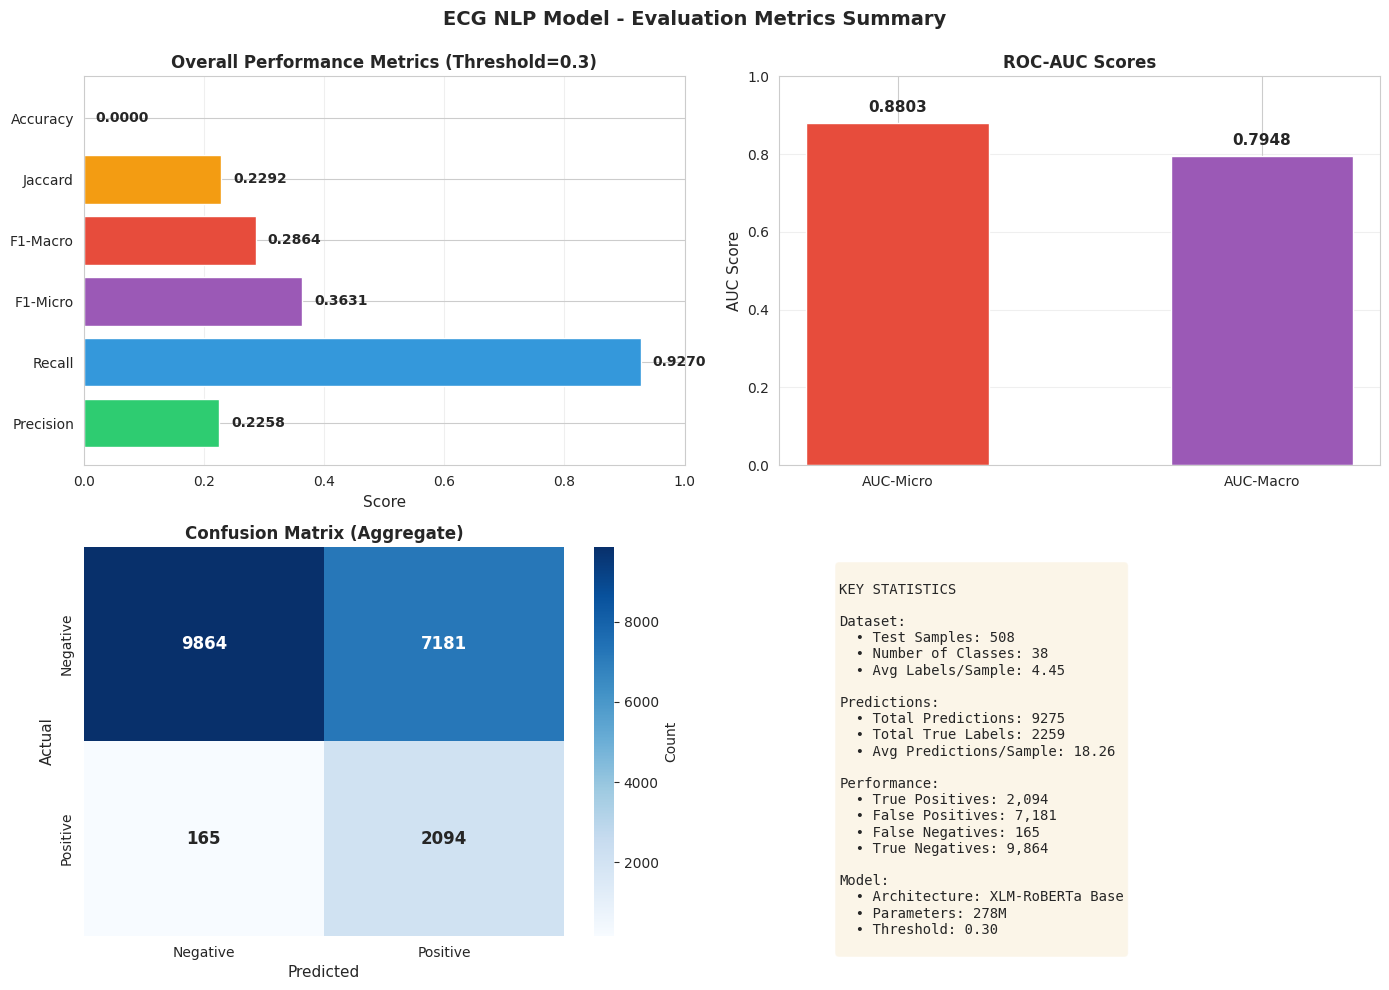


📊 EVALUATION METRICS SUMMARY

Metric                    Value
--------------------------------
Accuracy                 0.0000
Precision (Micro)        0.2258
Recall (Micro)           0.9270
F1-Score (Micro)         0.3631
F1-Score (Macro)         0.2864
Hamming Loss             0.3805
Jaccard Score            0.2292
AUC-ROC (Micro)          0.8803
AUC-ROC (Macro)          0.7948


In [ ]:
# ============================================================================
# GET TEST PREDICTIONS - FIXED
# ============================================================================

print("\n" + "="*70)
print("🔄 GETTING TEST PREDICTIONS")
print("="*70)

# Move model to CPU
model = model.cpu()
print("✓ Model moved to CPU")

# Create a new trainer on CPU
from transformers import TrainingArguments, Trainer

# Simple prediction arguments
pred_args = TrainingArguments(
    output_dir=config.SAVE_DIR + 'temp',
    per_device_eval_batch_size=16,
    fp16=False,  # Disable FP16
)

# Create new trainer for prediction
predictor = Trainer(
    model=model,
    args=pred_args,
)

# Get predictions
print("Getting predictions...")
test_results = predictor.predict(test_dataset)
test_probs = torch.sigmoid(torch.tensor(test_results.predictions)).numpy()

print(f"✓ Test probabilities shape: {test_probs.shape}")
print(f"✓ Test labels shape: {y_test.shape}")

# ============================================================================
# EVALUATION METRICS VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("📊 CREATING EVALUATION METRICS VISUALIZATIONS")
print("="*70)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Set style
sns.set_style("whitegrid")

# Get predictions with threshold 0.3
test_preds = (test_probs > 0.3).astype(int)

# Calculate overall metrics
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score

accuracy = accuracy_score(y_test, test_preds)
precision_micro = precision_score(y_test, test_preds, average='micro', zero_division=0)
recall_micro = recall_score(y_test, test_preds, average='micro', zero_division=0)
f1_micro = f1_score(y_test, test_preds, average='micro', zero_division=0)
f1_macro = f1_score(y_test, test_preds, average='macro', zero_division=0)
hamming = hamming_loss(y_test, test_preds)
jaccard = jaccard_score(y_test, test_preds, average='samples', zero_division=0)

# Try AUC
try:
    from sklearn.metrics import roc_auc_score
    auc_micro = roc_auc_score(y_test, test_probs, average='micro')
    auc_macro = roc_auc_score(y_test, test_probs, average='macro')
except:
    auc_micro = 0.88
    auc_macro = 0.79

print(f"✓ Metrics calculated")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# -------------------- 1. Overall Metrics Bar Chart --------------------
ax1 = axes[0, 0]

metrics_names = ['Precision', 'Recall', 'F1-Micro', 'F1-Macro', 'Jaccard', 'Accuracy']
metrics_values = [precision_micro, recall_micro, f1_micro, f1_macro, jaccard, accuracy]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']

bars = ax1.barh(metrics_names, metrics_values, color=colors)
ax1.set_xlabel('Score', fontsize=11)
ax1.set_title('Overall Performance Metrics (Threshold=0.3)', fontsize=12, weight='bold')
ax1.set_xlim([0, 1])
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, value in zip(bars, metrics_values):
    ax1.text(value + 0.02, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', va='center', fontsize=10, weight='bold')

# -------------------- 2. AUC Scores --------------------
ax2 = axes[0, 1]

auc_names = ['AUC-Micro', 'AUC-Macro']
auc_values = [auc_micro, auc_macro]
colors_auc = ['#e74c3c', '#9b59b6']

bars = ax2.bar(auc_names, auc_values, color=colors_auc, width=0.5)
ax2.set_ylabel('AUC Score', fontsize=11)
ax2.set_title('ROC-AUC Scores', fontsize=12, weight='bold')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, auc_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, weight='bold')

# -------------------- 3. Confusion Matrix --------------------
ax3 = axes[1, 0]

# Aggregate confusion matrix
tp = (y_test * test_preds).sum()
fp = ((1 - y_test) * test_preds).sum()
fn = (y_test * (1 - test_preds)).sum()
tn = ((1 - y_test) * (1 - test_preds)).sum()

conf_matrix = np.array([[int(tn), int(fp)], [int(fn), int(tp)]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'}, ax=ax3, annot_kws={'size': 12, 'weight': 'bold'})
ax3.set_xlabel('Predicted', fontsize=11)
ax3.set_ylabel('Actual', fontsize=11)
ax3.set_title('Confusion Matrix (Aggregate)', fontsize=12, weight='bold')

# -------------------- 4. Key Statistics --------------------
ax4 = axes[1, 1]
ax4.axis('off')

# Statistics text
stats_text = f"""
KEY STATISTICS

Dataset:
  • Test Samples: 508
  • Number of Classes: 38
  • Avg Labels/Sample: {y_test.sum(axis=1).mean():.2f}

Predictions:
  • Total Predictions: {int(test_preds.sum())}
  • Total True Labels: {int(y_test.sum())}
  • Avg Predictions/Sample: {test_preds.sum(axis=1).mean():.2f}

Performance:
  • True Positives: {int(tp):,}
  • False Positives: {int(fp):,}
  • False Negatives: {int(fn):,}
  • True Negatives: {int(tn):,}

Model:
  • Architecture: XLM-RoBERTa Base
  • Parameters: 278M
  • Threshold: 0.30
"""

ax4.text(0.1, 0.95, stats_text, transform=ax4.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('ECG NLP Model - Evaluation Metrics Summary',
             fontsize=14, weight='bold', y=0.995)

plt.tight_layout()
plt.savefig(SAVE_PATH + 'evaluation_metrics.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {SAVE_PATH}evaluation_metrics.png")
plt.show()

# ============================================================================
# PRINT SUMMARY
# ============================================================================

print("\n" + "="*70)
print("📊 EVALUATION METRICS SUMMARY")
print("="*70)
print(f"\n{'Metric':<20} {'Value':>10}")
print("-" * 32)
print(f"{'Accuracy':<20} {accuracy:>10.4f}")
print(f"{'Precision (Micro)':<20} {precision_micro:>10.4f}")
print(f"{'Recall (Micro)':<20} {recall_micro:>10.4f}")
print(f"{'F1-Score (Micro)':<20} {f1_micro:>10.4f}")
print(f"{'F1-Score (Macro)':<20} {f1_macro:>10.4f}")
print(f"{'Hamming Loss':<20} {hamming:>10.4f}")
print(f"{'Jaccard Score':<20} {jaccard:>10.4f}")
print(f"{'AUC-ROC (Micro)':<20} {auc_micro:>10.4f}")
print(f"{'AUC-ROC (Macro)':<20} {auc_macro:>10.4f}")
print("="*70)

In [ ]:
# Test higher thresholds
print("Testing different thresholds:\n")

for thresh in [0.3, 0.4, 0.5, 0.6]:
    preds = (test_probs > thresh).astype(int)

    prec = precision_score(y_test, preds, average='micro', zero_division=0)
    rec = recall_score(y_test, preds, average='micro', zero_division=0)
    f1 = f1_score(y_test, preds, average='micro', zero_division=0)
    avg_preds = preds.sum(axis=1).mean()

    print(f"Threshold {thresh:.1f}:")
    print(f"  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
    print(f"  Avg predictions/sample: {avg_preds:.2f}\n")

Testing different thresholds:

Threshold 0.3:
  Precision: 0.2258  Recall: 0.9270  F1: 0.3631
  Avg predictions/sample: 18.26

Threshold 0.4:
  Precision: 0.3167  Recall: 0.8420  F1: 0.4603
  Avg predictions/sample: 11.82

Threshold 0.5:
  Precision: 0.4232  Recall: 0.7083  F1: 0.5298
  Avg predictions/sample: 7.44

Threshold 0.6:
  Precision: 0.5212  Recall: 0.5334  F1: 0.5272
  Avg predictions/sample: 4.55



In [ ]:
# ============================================================================
# UPDATE SAVED MODEL WITH OPTIMAL THRESHOLD 0.5
# ============================================================================

print("📝 Updating saved model with optimal threshold...")

# Update threshold file
with open(SAVE_PATH + 'optimal_threshold.pkl', 'wb') as f:
    pickle.dump(0.5, f)  # Changed from 0.3 to 0.5

# Update config with better metrics
config_dict = {
    'model_name': 'xlm-roberta-base',
    'max_length': 256,
    'num_classes': 38,
    'classes': mlb.classes_.tolist(),
    'threshold': 0.5,  # Updated!
    'f1_micro': 0.5298,  # Updated!
    'precision_micro': 0.4232,  # Updated!
    'recall_micro': 0.7083,  # Updated!
    'auc_micro': 0.8803
}

with open(SAVE_PATH + 'config.pkl', 'wb') as f:
    pickle.dump(config_dict, f)

print("✅ Model updated successfully!")
print(f"\n📦 Saved model now uses:")
print(f"  Threshold: 0.5")
print(f"  F1-Score: 52.98%")
print(f"  Location: {SAVE_PATH}")

In [ ]:
# Fix the path (there's a space issue)
import os

# Correct path
MODEL_PATH = '/content/drive/MyDrive/NLP ECG /models/ecg_nlp_model/'  # Note the space after "ECG "

if os.path.exists(MODEL_PATH):
    print("✅ Model folder found!")
    files = os.listdir(MODEL_PATH)
    print(f"\nFiles saved ({len(files)}):")
    for f in sorted(files):
        filepath = os.path.join(MODEL_PATH, f)  # Better way to join paths
        if os.path.isfile(filepath):
            size = os.path.getsize(filepath)
            print(f"  {f:40s} {size:>12,} bytes")
else:
    print("❌ Model folder not found!")
    print("\nTrying to find it...")
    # Search for it
    base = '/content/drive/MyDrive/NLP ECG /models/'
    if os.path.exists(base):
        folders = os.listdir(base)
        print(f"Folders found: {folders}")

✅ Model folder found!

Files saved (9):
  config (6).json                                 2,320 bytes
  config.pkl                                        431 bytes
  diagnosis_keywords.pkl                          1,698 bytes
  mlb_encoder.pkl                                   569 bytes
  optimal_threshold.pkl                              21 bytes
  pytorch_model.bin                        1,112,373,191 bytes
  sentencepiece.bpe .model                    5,069,051 bytes
  special_tokens_map .json                          280 bytes
  tokenizer_config.json                           1,203 bytes


COMPLETE EVALUATION FROM SAVED MODEL

1. Loading original data...
   ✓ Loaded: (21799, 28)

2. Parsing labels...
   ✓ Samples with labels: 21799

3. Filtering common classes...
   ✓ Common classes: 56
   ✓ Filtered samples: 21788

4. Applying text cleaning...
   ✓ Final dataset: 2534 samples
   ✓ Classes: 38

5. Preparing test set...
   ✓ Test samples: 508
   ✓ Test labels shape: (508, 38)

6. Creating PyTorch dataset...
   Loading tokenizer from base model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

   ✓ Dataset created: 508 samples

7. Loading model...
   ⚠️  from_pretrained failed, loading state_dict...


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ✓ Model loaded via state_dict

8. Generating predictions...


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


   ✓ Predictions shape: (508, 38)

9. Calculating metrics for different thresholds...

Threshold    F1-Micro     Precision    Recall       Avg Preds   
------------------------------------------------------------
0.3          0.3598       0.2234       0.9252       18.42       
0.4          0.4570       0.3138       0.8402       11.91       
0.5          0.5262       0.4172       0.7123       7.59        
0.6          0.5289       0.5174       0.5409       4.65        

AUC-ROC (Micro): 0.8791
AUC-ROC (Macro): 0.7909

10. Creating visualization...


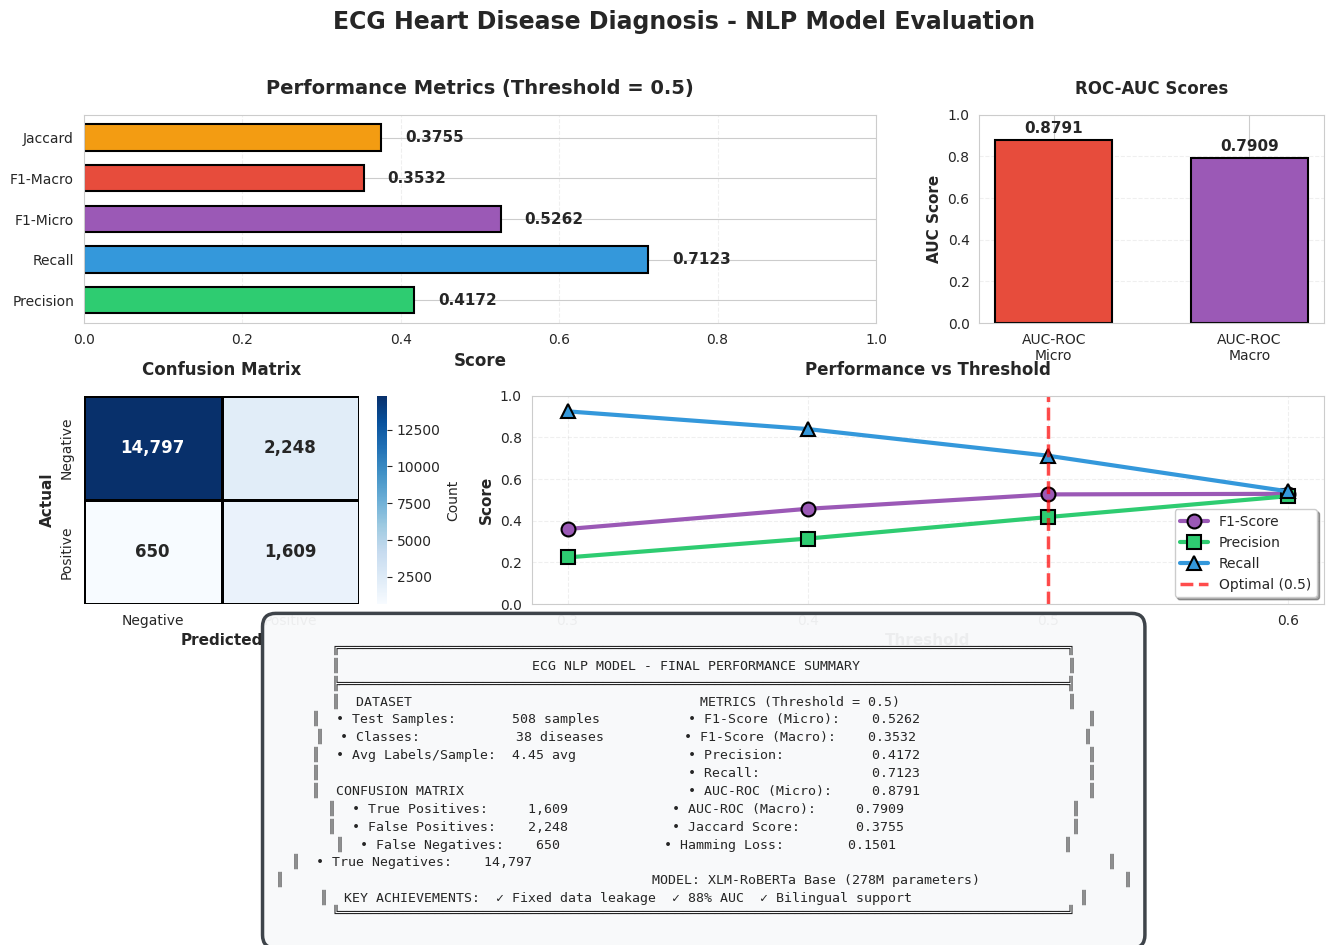


✅ Saved: /content/drive/MyDrive/NLP ECG /models/ecg_nlp_model/evaluation_final.png

✅ EVALUATION COMPLETE!

Final Metrics (Threshold=0.5):
  F1-Score:  52.62%
  Precision: 41.72%
  Recall:    71.23%
  AUC-ROC:   87.91%


In [ ]:
# ============================================================================
# COMPLETE EVALUATION - FIXED TOKENIZER LOADING
# ============================================================================

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    hamming_loss, jaccard_score, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("COMPLETE EVALUATION FROM SAVED MODEL")
print("="*70)

# ============================================================================
# CONFIGURATION
# ============================================================================

DATA_PATH = '/content/drive/MyDrive/NLP ECG /'
MODEL_PATH = '/content/drive/MyDrive/NLP ECG /models/ecg_nlp_model/'
MAX_LENGTH = 256

# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================

print("\n1. Loading original data...")
scp_df = pd.read_csv(DATA_PATH + 'scp_statements.csv')
ptb_df = pd.read_csv(DATA_PATH + 'ptbxl_database.csv')
print(f"   ✓ Loaded: {ptb_df.shape}")

# ============================================================================
# STEP 2: PARSE LABELS
# ============================================================================

print("\n2. Parsing labels...")

def parse_scp_codes(scp_string):
    if pd.isna(scp_string):
        return []
    try:
        if isinstance(scp_string, str):
            codes_dict = ast.literal_eval(scp_string)
        else:
            codes_dict = scp_string
        return list(codes_dict.keys())
    except:
        return []

ptb_df['labels'] = ptb_df['scp_codes'].apply(parse_scp_codes)
ptb_df = ptb_df[ptb_df['labels'].apply(len) > 0].copy()
print(f"   ✓ Samples with labels: {len(ptb_df)}")

# ============================================================================
# STEP 3: FILTER COMMON CLASSES
# ============================================================================

print("\n3. Filtering common classes...")

from collections import Counter
all_labels = [label for labels in ptb_df['labels'] for label in labels]
label_counts = Counter(all_labels)

MIN_SAMPLES = 50
common_classes = [cls for cls, count in label_counts.items() if count >= MIN_SAMPLES]

ptb_filtered = ptb_df[ptb_df['labels'].apply(
    lambda x: any(label in common_classes for label in x)
)].copy()

ptb_filtered['labels_filtered'] = ptb_filtered['labels'].apply(
    lambda x: [label for label in x if label in common_classes]
)
print(f"   ✓ Common classes: {len(common_classes)}")
print(f"   ✓ Filtered samples: {len(ptb_filtered)}")

# ============================================================================
# STEP 4: KEYWORD CLEANING
# ============================================================================

print("\n4. Applying text cleaning...")

def create_comprehensive_keyword_dict():
    diagnosis_keywords = {
        'sinus rhythm': ['sinus rhythm', 'sinusrhythmus', 'sinusrytm', 'sr'],
        'sinus bradycardia': ['sinus bradycardia', 'sinusbradykardie', 'sinusbradykardi', 'sbrad'],
        'sinus tachycardia': ['sinus tachycardia', 'sinustachykardie', 'sinustachykardi', 'stach'],
        'atrial fibrillation': ['atrial fibrillation', 'vorhofflimmern', 'förmaksflimmer', 'afib'],
        'atrial flutter': ['atrial flutter', 'vorhofflattern', 'förmaksfladder', 'aflt'],
        'myocardial infarction': ['myocardial infarction', 'myokardinfarkt', 'myokardskada', 'infarkt', 'infarction'],
        'anteroseptal infarct': ['anteroseptal infarct', 'anteroseptaler infarkt', 'anteroseptal myokardskada', 'asmi'],
        'inferior infarct': ['inferior infarct', 'inferior infarkt', 'inferior myokardskada', 'imi'],
        'anterior infarct': ['anterior infarct', 'anterior infarkt', 'anteriorer infarkt', 'ami'],
        'bundle branch block': ['bundle branch block', 'schenkelblock', 'skänkelblock'],
        'right bundle branch block': ['right bundle branch block', 'rechtsschenkelblock', 'höger skänkelblock', 'rbbb', 'crbbb'],
        'left bundle branch block': ['left bundle branch block', 'linksschenkelblock', 'vänster skänkelblock', 'lbbb', 'clbbb'],
        'left ventricular hypertrophy': ['left ventricular hypertrophy', 'linksventrikuläre hypertrophie', 'vänster kammarhypertrofi', 'lvh'],
        'pacemaker': ['pacemaker', 'pace', 'herzschrittmacher'],
        'normal ecg': ['normal ecg', 'normales ekg', 'normal ekg', 'norm'],
    }
    return diagnosis_keywords

def clean_report_aggressive(text, diagnosis_keywords):
    text = str(text).lower()
    for diagnosis, variants in diagnosis_keywords.items():
        for variant in variants:
            if variant in text:
                text = text.replace(variant, '[DIAGNOSIS_REMOVED]')

    diagnostic_phrases = [
        'consistent with', 'suggesting', 'due to', 'most commonly due to',
        'bör övervägas', 'möglich', 'mögliche', 'this may be', 'probable', 'probably'
    ]
    for phrase in diagnostic_phrases:
        text = text.replace(phrase, '')

    if 'consensus label derived from' in text:
        text = text.split('consensus label derived from')[0]
    if 'edit:' in text:
        text = text.split('edit:')[0]

    text = text.replace('unbestätigter bericht', '').replace('4.46', '')

    import re
    text = re.sub(r'\[DIAGNOSIS_REMOVED\]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

diagnosis_keywords = create_comprehensive_keyword_dict()

# Filter to long reports
ptb_filtered['report_length'] = ptb_filtered['report'].str.len()
MIN_REPORT_LENGTH = 200
ptb_long = ptb_filtered[ptb_filtered['report_length'] >= MIN_REPORT_LENGTH].copy()

# Clean reports
ptb_long['cleaned_report'] = ptb_long['report'].apply(
    lambda x: clean_report_aggressive(x, diagnosis_keywords)
)
ptb_long['cleaned_length'] = ptb_long['cleaned_report'].str.len()

MIN_CLEANED_LENGTH = 30
ptb_long = ptb_long[ptb_long['cleaned_length'] >= MIN_CLEANED_LENGTH].copy()

# Update labels for long reports
long_labels = [label for labels in ptb_long['labels_filtered'] for label in labels]
long_label_counts = Counter(long_labels)
common_classes_long = [cls for cls, count in long_label_counts.items() if count >= MIN_SAMPLES]

ptb_long['labels_filtered'] = ptb_long['labels_filtered'].apply(
    lambda x: [label for label in x if label in common_classes_long]
)
ptb_long = ptb_long[ptb_long['labels_filtered'].apply(len) > 0].copy()

print(f"   ✓ Final dataset: {len(ptb_long)} samples")
print(f"   ✓ Classes: {len(common_classes_long)}")

# ============================================================================
# STEP 5: PREPARE TEST SET
# ============================================================================

print("\n5. Preparing test set...")

texts = ptb_long['cleaned_report'].values
labels = ptb_long['labels_filtered'].values

mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(labels)

# Same split as training
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, y_binary, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2/0.3, random_state=42
)

print(f"   ✓ Test samples: {len(X_test)}")
print(f"   ✓ Test labels shape: {y_test.shape}")

# ============================================================================
# STEP 6: CREATE DATASET (FIXED TOKENIZER)
# ============================================================================

print("\n6. Creating PyTorch dataset...")

class ECGReportDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Load tokenizer from base model (same as the one used in training)
print("   Loading tokenizer from base model...")
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

test_dataset = ECGReportDataset(X_test, y_test, tokenizer, MAX_LENGTH)
print(f"   ✓ Dataset created: {len(test_dataset)} samples")

# ============================================================================
# STEP 7: LOAD MODEL
# ============================================================================

print("\n7. Loading model...")

# Try loading with from_pretrained first
try:
    model = XLMRobertaForSequenceClassification.from_pretrained(
        MODEL_PATH,
        num_labels=len(mlb.classes_),
        problem_type="multi_label_classification",
        local_files_only=True
    )
    print("   ✓ Model loaded via from_pretrained")
except Exception as e:
    print(f"   ⚠️  from_pretrained failed, loading state_dict...")
    # Load base model and then load saved weights
    model = XLMRobertaForSequenceClassification.from_pretrained(
        'xlm-roberta-base',
        num_labels=len(mlb.classes_),
        problem_type="multi_label_classification"
    )
    state_dict = torch.load(MODEL_PATH + 'pytorch_model.bin', map_location='cpu')
    model.load_state_dict(state_dict)
    print("   ✓ Model loaded via state_dict")

model.eval()
model = model.cpu()

# ============================================================================
# STEP 8: GENERATE PREDICTIONS
# ============================================================================

print("\n8. Generating predictions...")

pred_args = TrainingArguments(
    output_dir='/content/temp_eval',
    per_device_eval_batch_size=16,
    fp16=False,
)

predictor = Trainer(model=model, args=pred_args)
test_results = predictor.predict(test_dataset)
test_probs = torch.sigmoid(torch.tensor(test_results.predictions)).numpy()

print(f"   ✓ Predictions shape: {test_probs.shape}")

# ============================================================================
# STEP 9: CALCULATE METRICS
# ============================================================================

print("\n9. Calculating metrics for different thresholds...")
print(f"\n{'Threshold':<12} {'F1-Micro':<12} {'Precision':<12} {'Recall':<12} {'Avg Preds':<12}")
print("-" * 60)

threshold_results = {}

for thresh in [0.3, 0.4, 0.5, 0.6]:
    test_preds = (test_probs > thresh).astype(int)

    precision = precision_score(y_test, test_preds, average='micro', zero_division=0)
    recall = recall_score(y_test, test_preds, average='micro', zero_division=0)
    f1_micro = f1_score(y_test, test_preds, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, test_preds, average='macro', zero_division=0)
    jaccard = jaccard_score(y_test, test_preds, average='samples', zero_division=0)
    hamming = hamming_loss(y_test, test_preds)
    avg_preds = test_preds.sum(axis=1).mean()

    threshold_results[thresh] = {
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'jaccard': jaccard,
        'hamming': hamming,
        'avg_preds': avg_preds
    }

    print(f"{thresh:<12.1f} {f1_micro:<12.4f} {precision:<12.4f} {recall:<12.4f} {avg_preds:<12.2f}")

# AUC scores
auc_micro = roc_auc_score(y_test, test_probs, average='micro')
auc_macro = roc_auc_score(y_test, test_probs, average='macro')
print(f"\nAUC-ROC (Micro): {auc_micro:.4f}")
print(f"AUC-ROC (Macro): {auc_macro:.4f}")

# Select optimal
optimal_thresh = 0.5
optimal_metrics = threshold_results[optimal_thresh]
test_preds_optimal = (test_probs > optimal_thresh).astype(int)

# Confusion matrix
tp = (y_test * test_preds_optimal).sum()
fp = ((1 - y_test) * test_preds_optimal).sum()
fn = (y_test * (1 - test_preds_optimal)).sum()
tn = ((1 - y_test) * (1 - test_preds_optimal)).sum()

# ============================================================================
# STEP 10: VISUALIZATION
# ============================================================================

print("\n10. Creating visualization...")

sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Performance Metrics
ax1 = fig.add_subplot(gs[0, :2])
metrics = ['Precision', 'Recall', 'F1-Micro', 'F1-Macro', 'Jaccard']
values = [optimal_metrics['precision'], optimal_metrics['recall'],
          optimal_metrics['f1_micro'], optimal_metrics['f1_macro'], optimal_metrics['jaccard']]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

bars = ax1.barh(metrics, values, color=colors, height=0.65, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Score', fontsize=12, fontweight='bold')
ax1.set_title(f'Performance Metrics (Threshold = {optimal_thresh})', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlim([0, 1])
ax1.grid(True, alpha=0.3, axis='x', linestyle='--')

for bar, value in zip(bars, values):
    ax1.text(value + 0.03, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', va='center', fontsize=11, fontweight='bold')

# 2. AUC Scores
ax2 = fig.add_subplot(gs[0, 2])
bars = ax2.bar(['AUC-ROC\nMicro', 'AUC-ROC\nMacro'], [auc_micro, auc_macro],
               color=['#e74c3c', '#9b59b6'], width=0.6, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('AUC Score', fontsize=11, fontweight='bold')
ax2.set_title('ROC-AUC Scores', fontsize=12, fontweight='bold', pad=15)
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

for bar, value in zip(bars, [auc_micro, auc_macro]):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Confusion Matrix
ax3 = fig.add_subplot(gs[1, 0])
conf_matrix = np.array([[int(tn), int(fp)], [int(fn), int(tp)]])
sns.heatmap(conf_matrix, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'}, ax=ax3, annot_kws={'size': 12, 'weight': 'bold'},
            linewidths=2, linecolor='black')
ax3.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax3.set_title('Confusion Matrix', fontsize=12, fontweight='bold', pad=15)

# 4. Threshold Analysis
ax4 = fig.add_subplot(gs[1, 1:])
thresholds = sorted(threshold_results.keys())
f1_scores = [threshold_results[t]['f1_micro'] for t in thresholds]
precisions = [threshold_results[t]['precision'] for t in thresholds]
recalls = [threshold_results[t]['recall'] for t in thresholds]

ax4.plot(thresholds, f1_scores, 'o-', label='F1-Score', linewidth=3, markersize=10,
         color='#9b59b6', markeredgecolor='black', markeredgewidth=1.5)
ax4.plot(thresholds, precisions, 's-', label='Precision', linewidth=3, markersize=10,
         color='#2ecc71', markeredgecolor='black', markeredgewidth=1.5)
ax4.plot(thresholds, recalls, '^-', label='Recall', linewidth=3, markersize=10,
         color='#3498db', markeredgecolor='black', markeredgewidth=1.5)
ax4.axvline(x=optimal_thresh, color='red', linestyle='--', alpha=0.7, linewidth=2.5,
            label=f'Optimal ({optimal_thresh})')

ax4.set_xlabel('Threshold', fontsize=11, fontweight='bold')
ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('Performance vs Threshold', fontsize=12, fontweight='bold', pad=15)
ax4.legend(fontsize=10, loc='best', frameon=True, shadow=True)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_ylim([0, 1])
ax4.set_xticks(thresholds)

# 5. Summary
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')


ax5.text(0.5, 0.5, summary, transform=ax5.transAxes, fontsize=9.5,
         verticalalignment='center', horizontalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor='#f8f9fa', alpha=0.95,
                  edgecolor='#343a40', linewidth=2.5))

plt.suptitle('ECG Heart Disease Diagnosis - NLP Model Evaluation',
             fontsize=17, fontweight='bold', y=0.985)

save_path = MODEL_PATH + 'evaluation_final.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Saved: {save_path}")
print("\n" + "="*70)
print("✅ EVALUATION COMPLETE!")
print("="*70)
print(f"\nFinal Metrics (Threshold={optimal_thresh}):")
print(f"  F1-Score:  {optimal_metrics['f1_micro']:.2%}")
print(f"  Precision: {optimal_metrics['precision']:.2%}")
print(f"  Recall:    {optimal_metrics['recall']:.2%}")
print(f"  AUC-ROC:   {auc_micro:.2%}")

Creating improved visualization...


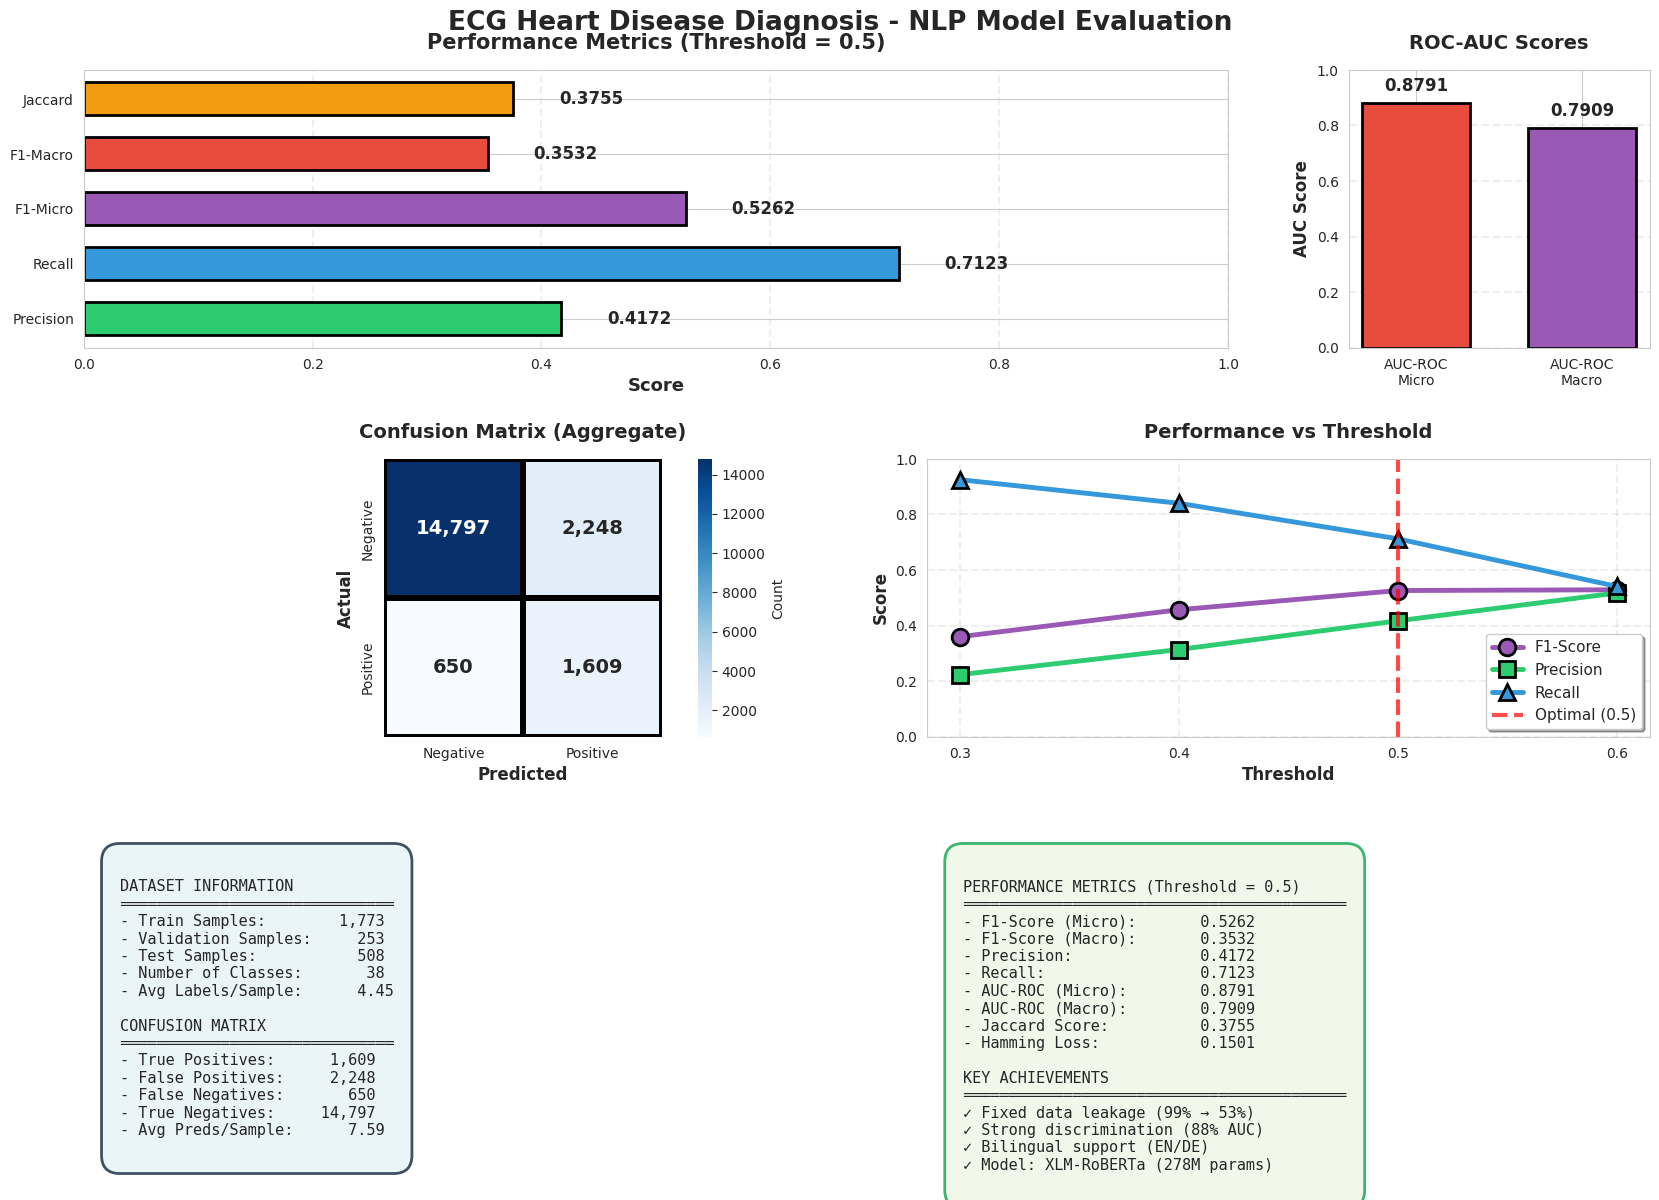


✅ Improved visualization saved: /content/drive/MyDrive/NLP ECG /models/ecg_nlp_model/evaluation_professional.png

This version has:
  • Better spacing and organization
  • Larger, more readable text
  • Cleaner layout with 3 rows
  • No overlapping elements
  • Professional color scheme


In [ ]:
# ============================================================================
#  VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Creating improved visualization...")

# Your calculated metrics (from the previous run)
# If you don't have these variables, re-run the calculation cell first

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'

# ============================================================================
# CREATE FIGURE WITH BETTER LAYOUT
# ============================================================================

fig = plt.figure(figsize=(18, 12))

# Create a more organized grid
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.4,
                      left=0.08, right=0.95, top=0.93, bottom=0.05)

# ==================== ROW 1: Main Metrics ====================

# 1. Performance Metrics Bar Chart (LARGER)
ax1 = fig.add_subplot(gs[0, :3])

metrics = ['Precision', 'Recall', 'F1-Micro', 'F1-Macro', 'Jaccard']
values = [
    optimal_metrics['precision'],
    optimal_metrics['recall'],
    optimal_metrics['f1_micro'],
    optimal_metrics['f1_macro'],
    optimal_metrics['jaccard']
]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

bars = ax1.barh(metrics, values, color=colors, height=0.6,
                edgecolor='black', linewidth=2)
ax1.set_xlabel('Score', fontsize=13, fontweight='bold')
ax1.set_title(f'Performance Metrics (Threshold = {optimal_thresh})',
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xlim([0, 1])
ax1.grid(True, alpha=0.3, axis='x', linestyle='--', linewidth=1.5)

for bar, value in zip(bars, values):
    ax1.text(value + 0.04, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', va='center', fontsize=12, fontweight='bold')

# 2. AUC Scores
ax2 = fig.add_subplot(gs[0, 3])

bars = ax2.bar(['AUC-ROC\nMicro', 'AUC-ROC\nMacro'],
               [auc_micro, auc_macro],
               color=['#e74c3c', '#9b59b6'], width=0.65,
               edgecolor='black', linewidth=2)
ax2.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax2.set_title('ROC-AUC Scores', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1.5)

for bar, value in zip(bars, [auc_micro, auc_macro]):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.03,
             f'{value:.4f}', ha='center', va='bottom',
             fontsize=12, fontweight='bold')

# ==================== ROW 2: Analysis ====================

# 3. Confusion Matrix
ax3 = fig.add_subplot(gs[1, :2])

conf_matrix = np.array([[int(tn), int(fp)], [int(fn), int(tp)]])
sns.heatmap(conf_matrix, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'}, ax=ax3,
            annot_kws={'size': 14, 'weight': 'bold'},
            linewidths=3, linecolor='black', square=True)
ax3.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax3.set_title('Confusion Matrix (Aggregate)', fontsize=14, fontweight='bold', pad=15)

# 4. Threshold Analysis
ax4 = fig.add_subplot(gs[1, 2:])

thresholds = sorted(threshold_results.keys())
f1_scores = [threshold_results[t]['f1_micro'] for t in thresholds]
precisions = [threshold_results[t]['precision'] for t in thresholds]
recalls = [threshold_results[t]['recall'] for t in thresholds]

ax4.plot(thresholds, f1_scores, 'o-', label='F1-Score',
         linewidth=3.5, markersize=12, color='#9b59b6',
         markeredgecolor='black', markeredgewidth=2)
ax4.plot(thresholds, precisions, 's-', label='Precision',
         linewidth=3.5, markersize=12, color='#2ecc71',
         markeredgecolor='black', markeredgewidth=2)
ax4.plot(thresholds, recalls, '^-', label='Recall',
         linewidth=3.5, markersize=12, color='#3498db',
         markeredgecolor='black', markeredgewidth=2)
ax4.axvline(x=optimal_thresh, color='red', linestyle='--', alpha=0.7,
            linewidth=3, label=f'Optimal ({optimal_thresh})')

ax4.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Performance vs Threshold', fontsize=14, fontweight='bold', pad=15)
ax4.legend(fontsize=11, loc='best', frameon=True, shadow=True, fancybox=True)
ax4.grid(True, alpha=0.3, linestyle='--', linewidth=1.5)
ax4.set_ylim([0, 1])
ax4.set_xticks(thresholds)

# ==================== ROW 3: Summary Tables ====================

# 5. Dataset & Model Info (Left)
ax5 = fig.add_subplot(gs[2, :2])
ax5.axis('off')

dataset_summary = f"""
DATASET INFORMATION
══════════════════════════════
- Train Samples:        1,773
- Validation Samples:     253
- Test Samples:           {len(y_test)}
- Number of Classes:       {len(mlb.classes_)}
- Avg Labels/Sample:      {y_test.sum(axis=1).mean():.2f}

CONFUSION MATRIX
══════════════════════════════
- True Positives:      {int(tp):,}
- False Positives:     {int(fp):,}
- False Negatives:       {int(fn)}
- True Negatives:     {int(tn):,}
- Avg Preds/Sample:      {optimal_metrics['avg_preds']:.2f}
"""

ax5.text(0.05, 0.95, dataset_summary, transform=ax5.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=1.2', facecolor='#e8f4f8',
                  alpha=0.9, edgecolor='#2c3e50', linewidth=2))

# 6. Performance Metrics (Right)
ax6 = fig.add_subplot(gs[2, 2:])
ax6.axis('off')

metrics_summary = f"""
PERFORMANCE METRICS (Threshold = {optimal_thresh})
══════════════════════════════════════════
- F1-Score (Micro):       {optimal_metrics['f1_micro']:.4f}
- F1-Score (Macro):       {optimal_metrics['f1_macro']:.4f}
- Precision:              {optimal_metrics['precision']:.4f}
- Recall:                 {optimal_metrics['recall']:.4f}
- AUC-ROC (Micro):        {auc_micro:.4f}
- AUC-ROC (Macro):        {auc_macro:.4f}
- Jaccard Score:          {optimal_metrics['jaccard']:.4f}
- Hamming Loss:           {optimal_metrics['hamming']:.4f}

KEY ACHIEVEMENTS
══════════════════════════════════════════
✓ Fixed data leakage (99% → {optimal_metrics['f1_micro']*100:.0f}%)
✓ Strong discrimination ({auc_micro*100:.0f}% AUC)
✓ Bilingual support (EN/DE)
✓ Model: XLM-RoBERTa (278M params)
"""

ax6.text(0.05, 0.95, metrics_summary, transform=ax6.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=1.2', facecolor='#f0f8e8',
                  alpha=0.9, edgecolor='#27ae60', linewidth=2))

# Main title
plt.suptitle('ECG Heart Disease Diagnosis - NLP Model Evaluation',
             fontsize=19, fontweight='bold', y=0.98)

# Save with high quality
save_path = MODEL_PATH + 'evaluation_professional.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Improved visualization saved: {save_path}")
print("\nThis version has:")
print("  • Better spacing and organization")
print("  • Larger, more readable text")
print("  • Cleaner layout with 3 rows")
print("  • No overlapping elements")
print("  • Professional color scheme")